# Analysis of the latent space of nonlinear autoencoders with an unsteady laminar wake

In [27]:
import matplotlib
matplotlib.rcParams['image.cmap']='jet'
import matplotlib.pyplot as plt
import h5py
import jax
import numpy as np
import jax.numpy as jnp
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
mse = tf.keras.losses.MeanSquaredError()

from mpl_toolkits.axes_grid1 import ImageGrid
from numpy import einsum
from pathlib import Path
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from MD_AE_tools.mode_decomposition import POD
from MD_AE_tools.models.models_no_bias import Autoencoder, Decoder
from project_specific_utils import my_discrete_cmap, my_continuous_cmap
new_grey = '#C0C0C0'
z_colour = (my_discrete_cmap(0),my_discrete_cmap(2),my_discrete_cmap(3))

## Set up system
Please change the parameters in this section to fit your computer.

In [29]:
## Path to data and model weights
datapath = Path('./data/cylinder/ux.h5')
path_trained_model_weights = Path('./_weights/weights_ae2.h5')

In [28]:
## GPU set-up, ignore if no GPUs are available
system_gpu_number = 0 # which gpu to use 
system_gpu_memory = 2048 # how much gpu memory to allocate this notebook in MB

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[system_gpu_number], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[system_gpu_number],[tf.config.LogicalDeviceConfiguration(memory_limit=system_gpu_memory)]) # set hard memory limit
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


## Load data
Loading and pre-process the laminar wake

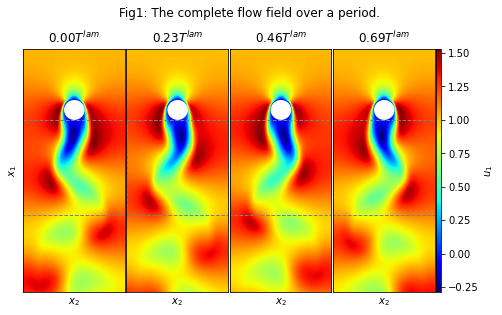

In [45]:
with h5py.File(datapath,'r') as hf:
    ux_complete = np.array(hf.get('ux'))
(nt,_,nx2) = ux_complete.shape
dt = 0.0002*625 # Time elapsed between snapshots = dt used in CFD (0.0002) * steps between saving each snapshot (625)
freq_main = 0.23 # Hz
realt = np.arange(nt)*dt
realt_as_period = realt/(1/freq_main)

## Plot the entire flow field
fig = plt.figure(figsize=(7,4.5))
fig.suptitle('Fig1: The complete flow field over a period.')
grid = ImageGrid(fig,(0.05,0.0,0.83,0.95),(1,4),cbar_mode='single',share_all=True)
for i, ax in enumerate(grid.axes_all):
    im = ax.imshow(ux_complete[i*8,:,:],'jet')
    ax.set(xticks=[],yticks=[],title=f'${realt_as_period[i*8]:.2f}$'+'$T^{lam}$',ylabel='$x_1$',xlabel='$x_2$',aspect=12/20)
    circle = matplotlib.patches.Ellipse((64.5,128.25),26,42,facecolor='white',edgecolor='none')
    domain = matplotlib.patches.Rectangle((0,150),129,200,linewidth=1,edgecolor='grey',facecolor='none',linestyle='--')
    ax.add_patch(domain)
    ax.add_patch(circle)
grid.cbar_axes[0].colorbar(im,label='$u_1$')
plt.show()

### Pre-processing the data
Two steps are necessary:
1. Only a part of the near wake is considered, shown as the area inside the dashed lines in Fig1. 
2. Perform POD. The POD modes modes of the reference data (data modes $\pmb{\Phi}$) are needed for comparison and for applying the decoder decomposition. 

In [46]:
## Data used for training
nx1 = 200 # how many grid points to use in x1 direction.
ux = ux_complete[:,150:150+nx1,:].reshape((nt,nx1,nx2))
utrain = ux - np.mean(ux,axis=0,keepdims=True)
utrain = utrain.reshape((nt,nx1,nx2,1)) # Train on fluctuating velocity

## Decompose with POD
pod_data = POD(einsum('t x y -> x y t',np.squeeze(ux)),keep_shape=True)
modes,lam = pod_data.get_modes
a_data = pod_data.Q.T @ modes.reshape((-1,800))

## Compute frequency
fftfreq = np.fft.fftfreq(800,0.0002*625)
freq_data = einsum('t x y -> t',np.abs(np.fft.fft(ux-np.mean(ux,axis=0),axis=0)))
freq_data = freq_data / np.std(freq_data)
freq_a_data = np.abs(np.fft.fft(a_data-np.mean(a_data,axis=0),axis=0))
freq_a_data = freq_a_data / np.std(freq_a_data,0)

Calculating POD ...
Use snapshot POD, Nx > Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:240: RuntimeWarning: invalid value encountered in sqrt
  Q_POD = (Q@Phi)*(1/(lam**0.5).T)


POD done.


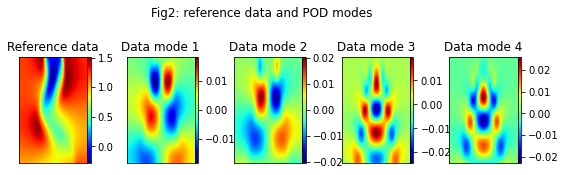

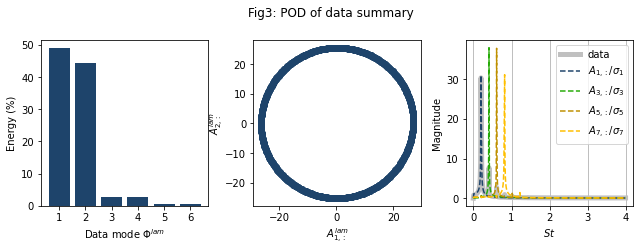

In [51]:
## Plot summary of the reference data
fig = plt.figure(figsize=(9,3))
fig.suptitle('Fig2: reference data and POD modes')
grid = ImageGrid(fig, 111, (1,5), share_all=True, cbar_mode='each', axes_pad=0.5, cbar_pad=0)
im = grid.axes_all[0].imshow(ux[0,:,:])
grid.axes_all[0].set_title('Reference data')
grid.cbar_axes[0].colorbar(im)
for i, (ax,cax) in enumerate(zip(grid.axes_all[1:],grid.cbar_axes[1:])):
    im = ax.imshow(modes[...,i])
    ax.set(xticks=[],yticks=[],title=f'Data mode {i+1}')
    cax.colorbar(im)


fig,axes = plt.subplots(1,3,figsize=(9,3.5))
fig.suptitle('Fig3: POD of data summary')
fig.tight_layout()
axes[0].bar(range(1,7),100*lam[:6]/np.sum(lam),color=my_discrete_cmap(0))
axes[0].set(xticks=[1,2,3,4,5,6],xlabel='Data mode $\Phi^{lam}$',ylabel='Energy (%)')
axes[1].scatter(a_data[:,0],a_data[:,1],color=my_discrete_cmap(0))
axes[1].set_ylabel('$A^{lam}_{2,:}$',labelpad=-0.5)
axes[1].set_xlabel('$A^{lam}_{1,:}$')
plt.subplots_adjust(bottom=0.19)
axes[2].plot(fftfreq[:400],(freq_data*2)[:400],color=new_grey,linewidth=5,label='data')
for i in [0,2,4,6]:
    axes[2].plot(fftfreq[:400],(freq_a_data[:,i]*2)[:400],'--',label='$A_{'+str(i+1)+',:}$/$\sigma_{'+str(i+1)+'}$',color=my_continuous_cmap(i/6))
axes[2].set_xlabel('$St$')
axes[2].set_ylabel('Magnitude')
axes[2].grid(axis='x')
axes[2].legend()

plt.show()

## Train an autoencoder
In this section, we look at a nonlinear autoencoder (AE) with two latent variables trained on the laminar wake. The model is a convolution autoencoder with no bias.
The bias terms are no used because we train the AE on the fluctuating velocity.

### Define model parameters and model

In [33]:
# model config
features_layers = [8, 16, 32] # Number of channels for each convolution layer
latent_dim = 2 # latent dimension
act_fct = 'tanh' # activation function
filter_window= (3,3)

# training config 
nb_epochs = 3000 # Number of epochs
batch_size = 100
learning_rate = 0.001 

nu = 1 # Data has only one velocity component
flow_grid = [nx1, nx2]

In [34]:
ae = Autoencoder(
    flow_grid,
    nu,
    features_layers=features_layers,
    latent_dim=latent_dim,
    filter_window=filter_window,
    act_fct=act_fct,
)
ae.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 129, 1)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 2)                 33034     
                                                                 
 decoder_1 (Decoder)         (None, 200, 129, 1)       46632     
                                                                 
Total params: 79,666
Trainable params: 79,666
Non-trainable params: 0
_________________________________________________________________


### Train model
There are two options here. Please run only one of the options.
1. load the provided weights from a trained autoencoder. This will produce identical results to the paper.
2. Train and autoencoder from scratch. This takes about 15mins on a NVIDIA RTX8000 GPU. This will provide you with similar results to the paper.

In [52]:
## Option 1: Load a trained model 
ae.evaluate(utrain, utrain, verbose=0)
ae.load_weights(path_trained_model_weights)
train_model_loss = ae.evaluate(utrain, utrain, verbose=0)
print(f'The trained model has loss (MSE {train_model_loss})')

## Option 2: Train a new model
# loss_ae = []
# tempfn_ae = './temp_weights.h5'
# model_cb = ModelCheckpoint(tempfn_ae, monitor='loss', save_best_only=True,verbose=0, save_weights_only=True)
# cb = [model_cb]
# histae = ae.fit(
#     utrain, 
#     utrain,
#     epochs=nb_epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     callbacks=cb,
#     verbose=2
# )
# loss_ae.extend(histae.history['loss'])
# ae.load_weights(tempfn_ae) # loading the weight weights
# plt.figure()
# plt.semilogy(loss_ae)
# plt.xlabel('epoch')
# plt.ylabel('MSE')
# plt.show()
# print(f'Average loss of the last 100 epochs: {np.mean(loss_ae[-100:])}')

The trained model has loss (MSE 5.456475719256559e-06)


In [53]:
## Get output of the AE
z_ae = ae.encoder.predict(utrain)
ae_pred = np.squeeze(ae.predict(utrain))

## Results

We relate the data modes with the latent variables via decoder decomposition. 

We define the decoder coefficients $\pmb{B}$ so that the output of the AE $\hat{\pmb{Y}} = \pmb{\Phi}\pmb{B}$. 
Meaning that $\frac{d\hat{\pmb{Y}}}{d\pmb{Z}}=\pmb{\Phi}\frac{d\pmb{B}}{d\pmb{Z}}$.


We can then compute the average absolute rate of change $\epsilon_{i,j}$, which tells us the relative importance of $\pmb{B}_{j,:}$ due to the latent variable $\pmb{Z}_{i,:}$.

**
$\epsilon_{i,j} = \frac{
        \int | \frac{dB_{j,:}}{dZ_{i,:}}| dZ_{1,:}\dots dZ_{N_z,:}
    }{
        \int dZ_{1,:}\dots dZ_{N_z,:}
}$
**

Practically, we compute $\frac{d\hat{\pmb{Y}}}{d\pmb{Z}}$ first using the function ```local_partial_derivative```.

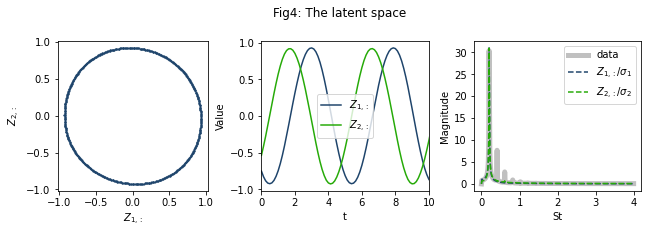

In [54]:
freq_z = np.abs(np.fft.fft(z_ae-np.mean(z_ae,axis=0),axis=0))
freq_z = freq_z / np.std(freq_z,0)

fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Fig4: The latent space')
fig.tight_layout()
ax0.scatter(z_ae[:,0],z_ae[:,1],s=1,color=my_discrete_cmap(0))
ax0.set(aspect='equal',xlabel='$Z_{1,:}$',ylabel='$Z_{2,:}$')
ax1.plot(realt,z_ae[:,0],label='$Z_{1,:}$',color=my_discrete_cmap(0))
ax1.plot(realt,z_ae[:,1],label='$Z_{2,:}$',color=my_discrete_cmap(2))
ax1.set(xlabel='t',ylabel='Value',xlim=[0,10])
ax1.legend()
ax2.plot(fftfreq[:400],(freq_data*2)[:400],c=new_grey,linewidth=5,label='data')
for i in range(latent_dim):
    ax2.plot(fftfreq[:400],(freq_z[:,i]*2)[:400],'--',label='$'+'Z_{'+str({i+1})+',:}$/$\sigma_{'+str(i+1)+'}$',color=z_colour[i])
ax2.set(ylabel='Magnitude', xlabel='St')
ax2.legend()
plt.show()

In [55]:
def local_partial_derivative(decoder:Decoder, z: np.array, h:float, batch_size:int):
    """Compute dy/dz of a trained decoder.
    
    -----------------
    Input:
    - decoder: a trained decoder. For example ae.decoder
    - z: the latent vector, output of an encoder, with shape (nt,nz)
    - h: step size, used to calculate derivatives
    - batch size: the batch size to pass into decoder.predict
    """

    (nt,nz) = z.shape
    (_,_nx,_ny,_nu) = decoder.predict(z[[0],:]).shape
    n = _nx*_ny*_nu

    dydz = np.zeros((nz,nt,n))

    for i in range(nz):

        hi = np.zeros((1,nz))
        hi[0,i] = h #[1,Nz]

        z_left = z + hi
        z_right = z - hi

        f_z_left = decoder.predict(z_left, batch_size=batch_size).reshape((nt,n))
        f_z_right = decoder.predict(z_right, batch_size=batch_size).reshape((nt,n))
        dydz_i = (f_z_left - f_z_right) / (2*h) #[Nt,N]

        dydz[i,:,:] = dydz_i
    
    return dydz.reshape((nz,nt,_nx,_ny,nu))


In [56]:
dydz = local_partial_derivative(ae.decoder,z_ae,0.001,batch_size)[...,0]
dbdz = jnp.einsum('z t x y, x y m -> z t m', dydz, modes)
avgbz = jnp.mean(jnp.abs(dbdz),axis=1)

/tmp/ipykernel_235118/3316432365.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticks=[], xticklabels=np.arange(0,7))


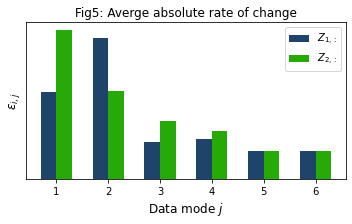

In [57]:
fig,ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(1,7)-0.15,avgbz[0,:6],width=0.3,label='$Z_{1,:}$',color=z_colour[0])
ax.bar(np.arange(1,7)+0.15,avgbz[1,:6],width=0.3,label='$Z_{2,:}$',color=z_colour[1])
ax.set(yticks=[], xticklabels=np.arange(0,7))
ax.set_ylabel(ylabel='$\epsilon_{i,j}$',fontsize='large')
ax.set_xlabel(xlabel='Data mode $j$',fontsize='large')
ax.legend()
fig.tight_layout()
plt.title('Fig5: Averge absolute rate of change')
plt.show()

Plot all valid values on a contour plot.

This produces contour plots for the first four decoder coefficients for all values of the latent variables between -1 and 1. The grey circle on the plots are the observed latent variables.

In [58]:
def get_b_hold_z1_constant(y_i,modes):
    b_i = jnp.einsum('t x y, x y m -> t m', jnp.squeeze(y_i),modes)
    return b_i

z1 = np.linspace(-0.99,0.99,101).astype('float32')
z2 = np.linspace(-0.99,0.99,101).astype('float32')
idx_z2_0 = np.squeeze(np.argwhere(np.abs(z2-0)<1.19209e-07))
idx_z1_0 = np.squeeze(np.argwhere(np.abs(z1-0)<1.19209e-07))
zx,zy = np.meshgrid(z1,z2)
_y_grid =[]
for i in range(len(z1)):
    y_i = ae.decoder.predict(
        tf.stack((zx[:,i],zy[:,0]),axis=1)
    )
    _y_grid.append(y_i)
_y_grid = np.array(_y_grid)

v_get_b_gridded = jax.vmap(get_b_hold_z1_constant,in_axes=(0,None))
ae_b_post_gridded = v_get_b_gridded(_y_grid,modes[...,:6]) #[z1,z2,modes]

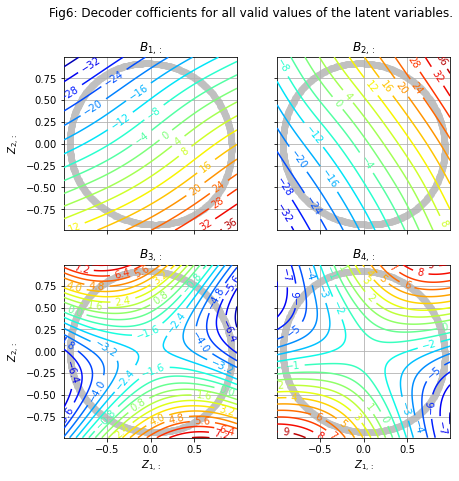

In [60]:
fig,ax = plt.subplots(2,2,figsize=(7,7),sharex=True,sharey=True)
fig.suptitle('Fig6: Decoder cofficients for all valid values of the latent variables.')
ax_flat = ax.flatten()
for i in range(4):
    cs = ax_flat[i].contour(zx,zy,ae_b_post_gridded[:,:,i].T,levels=20,zorder=5)
    ax_flat[i].clabel(cs)
    ax_flat[i].grid()
    ax_flat[i].scatter(z_ae[:,0],z_ae[:,1],zorder=1,c=new_grey,alpha=0.5)
    ax_flat[i].set_aspect('equal')
ax_flat[2].set(xlabel='$Z_{1,:}$',ylabel='$Z_{2,:}$')
ax_flat[0].set(ylabel='$Z_{2,:}$')
ax_flat[3].set(xlabel='$Z_{1,:}$')
ax_flat[0].set_title('$B_{1,:}$',fontsize='large')
ax_flat[1].set_title('$B_{2,:}$',fontsize='large')
ax_flat[2].set_title('$B_{3,:}$',fontsize='large')
ax_flat[3].set_title('$B_{4,:}$',fontsize='large')
plt.show()

## Different latent dimension

The dimension of the latent space has a significant impact on the interpretation of the latent variables. 
Here shows an example where the latent dimension is $1$ (too small). 
Because the reference data contains periodocity, which cannot be expressed in AE with one latent variable, the latent variable are force to take up higher, unphysical frequency to achieve numerical approximation.

You can also play around with the latent dimension to see what happens.

In [12]:
# model config
latent_dim1 = 1 # latent dimension
nb_epochs1 = 3000 # Number of epochs

In [13]:
ae1 = Autoencoder(
    flow_grid,
    nu,
    features_layers=features_layers,
    latent_dim=latent_dim1,
    filter_window=filter_window,
    act_fct=act_fct,
)
ae1.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
ae1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 129, 1)]     0         
                                                                 
 encoder (Encoder)           (None, 1)                 19433     
                                                                 
 decoder (Decoder)           (None, 200, 129, 1)       33032     
                                                                 
Total params: 52,465
Trainable params: 52,465
Non-trainable params: 0
_________________________________________________________________


In [61]:
## Option 1: Load a trained model 
ae1.evaluate(utrain, utrain, verbose=0)
ae1.load_weights('_weights/weights_ae1.h5')
train_model_loss = ae1.evaluate(utrain, utrain, verbose=0)
print(f'The trained model has loss (MSE {train_model_loss})')

# # Option 2: Train a new model
# loss_ae1 = []
# tempfn_ae1 = './temp_weights1.h5'
# model_cb = ModelCheckpoint(tempfn_ae1, monitor='loss', save_best_only=True,verbose=0, save_weights_only=True)
# cb = [model_cb]
# histae1 = ae1.fit(
#     utrain, 
#     utrain,
#     epochs=nb_epochs1,
#     batch_size=batch_size,
#     shuffle=True,
#     callbacks=cb,
#     verbose=2
# )
# loss_ae1.extend(histae1.history['loss'])
# ae1.load_weights(tempfn_ae1) # loading the weight weights
# plt.figure()
# plt.semilogy(loss_ae1)
# plt.xlabel('epoch')
# plt.ylabel('MSE')
# plt.show()
# print(f'Average loss of the last 100 epochs: {np.mean(loss_ae1[-100:])}')

## Get output of the AE
z_ae1 = ae1.encoder.predict(utrain)
ae_pred1 = np.squeeze(ae1.predict(utrain))

The trained model has loss (MSE 0.0011491348268464208)


In [63]:
freq_z1.shape

(800, 1)

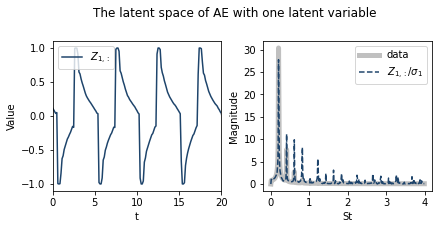

In [66]:
freq_z1 = np.abs(np.fft.fft(z_ae1-np.mean(z_ae1,axis=0),axis=0))
freq_z1 = freq_z1 / np.std(freq_z1,0)

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(6,3))
fig.suptitle('The latent space of AE with one latent variable')
fig.tight_layout()
for i in range(latent_dim1):
    ax0.plot(realt,z_ae1[:,0],label='$Z_{'+str(i+1)+',:}$',color=my_continuous_cmap(i/latent_dim1))
ax0.set(xlabel='t',ylabel='Value',xlim=[0,20])
ax0.legend()
ax1.plot(fftfreq[:400],(freq_data*2)[:400],c=new_grey,linewidth=5,label='data')
for i in range(latent_dim1):
    ax1.plot(fftfreq[:400],(freq_z1[:,i]*2)[:400],'--',label='$'+'Z_{'+str({i+1})+',:}$/$\sigma_{'+str(i+1)+'}$',color=z_colour[i])
ax1.set(ylabel='Magnitude', xlabel='St')
ax1.legend()
plt.show()